<a href="https://colab.research.google.com/github/njpinton/CMSC173/blob/main/LinearRegression/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
np.random.seed(42)

This section demonstrates the fundamental difference between linear and logistic regression.
Linear regression predicts continuous values using a straight line, while logistic regression
predicts probabilities (0-1) using the sigmoid function for binary classification.
We'll visualize why linear regression fails for classification tasks.

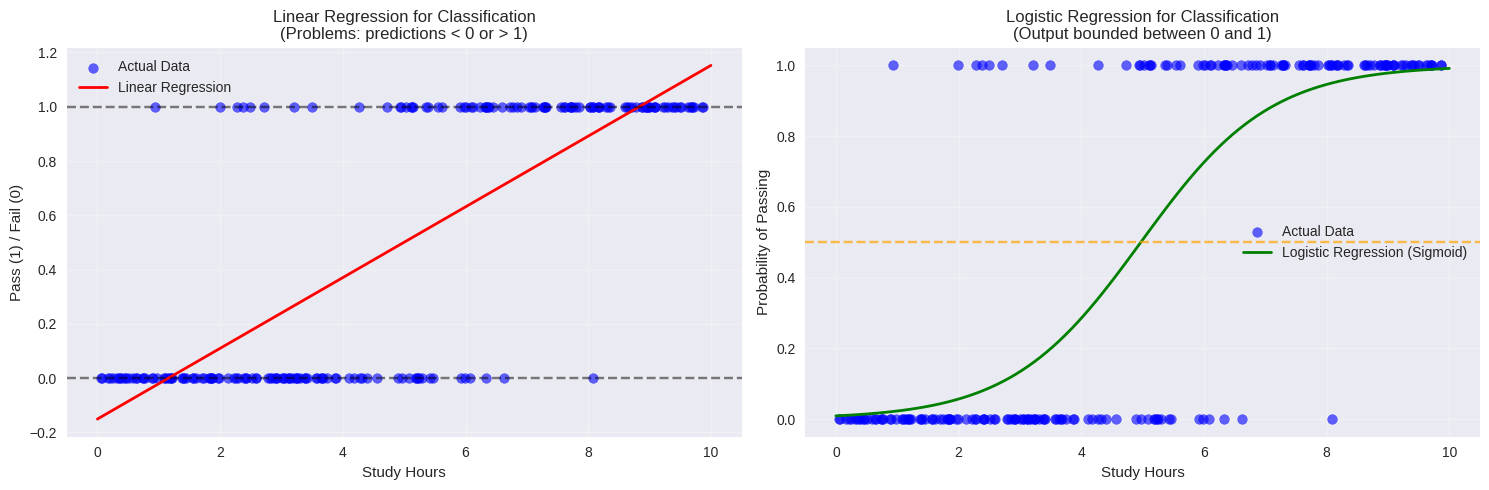

In [2]:
# Generate synthetic binary classification data
np.random.seed(42)
n_samples = 200
X_hours = np.random.uniform(0, 10, n_samples)
# Create probability based on study hours (more hours = higher chance of passing)
prob_pass = 1 / (1 + np.exp(-(X_hours - 5)))  # Sigmoid function centered at 5 hours
y_pass = np.random.binomial(1, prob_pass)

# Reshape for sklearn
X_hours_reshaped = X_hours.reshape(-1, 1)

# Fit both models
linear_model = LinearRegression()
logistic_model = LogisticRegression()

linear_model.fit(X_hours_reshaped, y_pass)
logistic_model.fit(X_hours_reshaped, y_pass)

# Create prediction range
X_range = np.linspace(0, 10, 100).reshape(-1, 1)
linear_pred = linear_model.predict(X_range)
logistic_prob = logistic_model.predict_proba(X_range)[:, 1]

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Linear Regression Plot
ax1.scatter(X_hours, y_pass, alpha=0.6, c='blue', label='Actual Data')
ax1.plot(X_range, linear_pred, 'r-', linewidth=2, label='Linear Regression')
ax1.set_xlabel('Study Hours')
ax1.set_ylabel('Pass (1) / Fail (0)')
ax1.set_title('Linear Regression for Classification\n(Problems: predictions < 0 or > 1)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)
ax1.axhline(y=1, color='k', linestyle='--', alpha=0.5)

# Logistic Regression Plot
ax2.scatter(X_hours, y_pass, alpha=0.6, c='blue', label='Actual Data')
ax2.plot(X_range, logistic_prob, 'g-', linewidth=2, label='Logistic Regression (Sigmoid)')
ax2.set_xlabel('Study Hours')
ax2.set_ylabel('Probability of Passing')
ax2.set_title('Logistic Regression for Classification\n(Output bounded between 0 and 1)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Decision Boundary')

plt.tight_layout()
plt.show()

The sigmoid function is the core of logistic regression. It transforms any real number
into a probability between 0 and 1. Formula: σ(z) = 1 / (1 + e^(-z))
where z = β₀ + β₁x₁ + β₂x₂ + ... + βₙxₙ (linear combination)
This section explores how the sigmoid function behaves with different parameters.

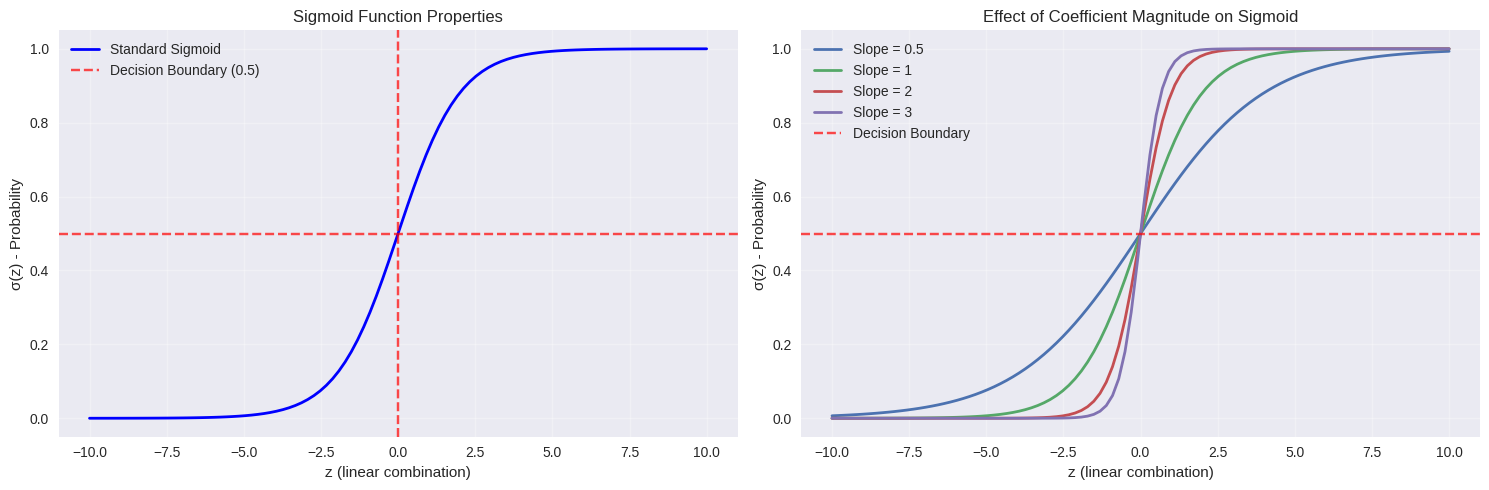

In [3]:
def sigmoid(z):
    """Sigmoid activation function"""
    return 1 / (1 + np.exp(-np.clip(z, -500, 500)))  # Clip to prevent overflow

# Demonstrate sigmoid with different parameters
z_values = np.linspace(-10, 10, 100)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Basic sigmoid
ax1.plot(z_values, sigmoid(z_values), 'b-', linewidth=2, label='Standard Sigmoid')
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Decision Boundary (0.5)')
ax1.axvline(x=0, color='r', linestyle='--', alpha=0.7)
ax1.set_xlabel('z (linear combination)')
ax1.set_ylabel('σ(z) - Probability')
ax1.set_title('Sigmoid Function Properties')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Sigmoid with different slopes (representing different coefficients)
for slope in [0.5, 1, 2, 3]:
    ax2.plot(z_values, sigmoid(slope * z_values), linewidth=2, label=f'Slope = {slope}')
ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.7, label='Decision Boundary')
ax2.set_xlabel('z (linear combination)')
ax2.set_ylabel('σ(z) - Probability')
ax2.set_title('Effect of Coefficient Magnitude on Sigmoid')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

In [4]:
# Create a synthetic Titanic-like dataset for demonstration
np.random.seed(42)
n_passengers = 1000

# Generate synthetic passenger data
data = {
    'Age': np.random.normal(30, 12, n_passengers),
    'Fare': np.random.lognormal(3, 1, n_passengers),
    'Pclass': np.random.choice([1, 2, 3], n_passengers, p=[0.2, 0.3, 0.5]),
    'Sex': np.random.choice([0, 1], n_passengers)  # 0: male, 1: female
}

# Create survival probability based on realistic factors
survival_prob = (
    0.1 +  # Base survival rate
    0.4 * data['Sex'] +  # Females more likely to survive
    0.2 * (data['Pclass'] == 1) +  # First class advantage
    0.1 * (data['Pclass'] == 2) +  # Second class slight advantage
    0.01 * np.clip((data['Age'] - 20) / 50, -0.2, 0.2) +  # Age factor
    0.1 * np.clip(data['Fare'] / 100, 0, 0.3)  # Higher fare advantage
)

data['Survived'] = np.random.binomial(1, np.clip(survival_prob, 0, 1), n_passengers)

# Convert to DataFrame
df = pd.DataFrame(data)
df['Age'] = np.clip(df['Age'], 1, 80)  # Realistic age bounds

print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"Survival Rate: {df['Survived'].mean():.2%}")

Dataset Overview:
Shape: (1000, 5)
Survival Rate: 37.80%


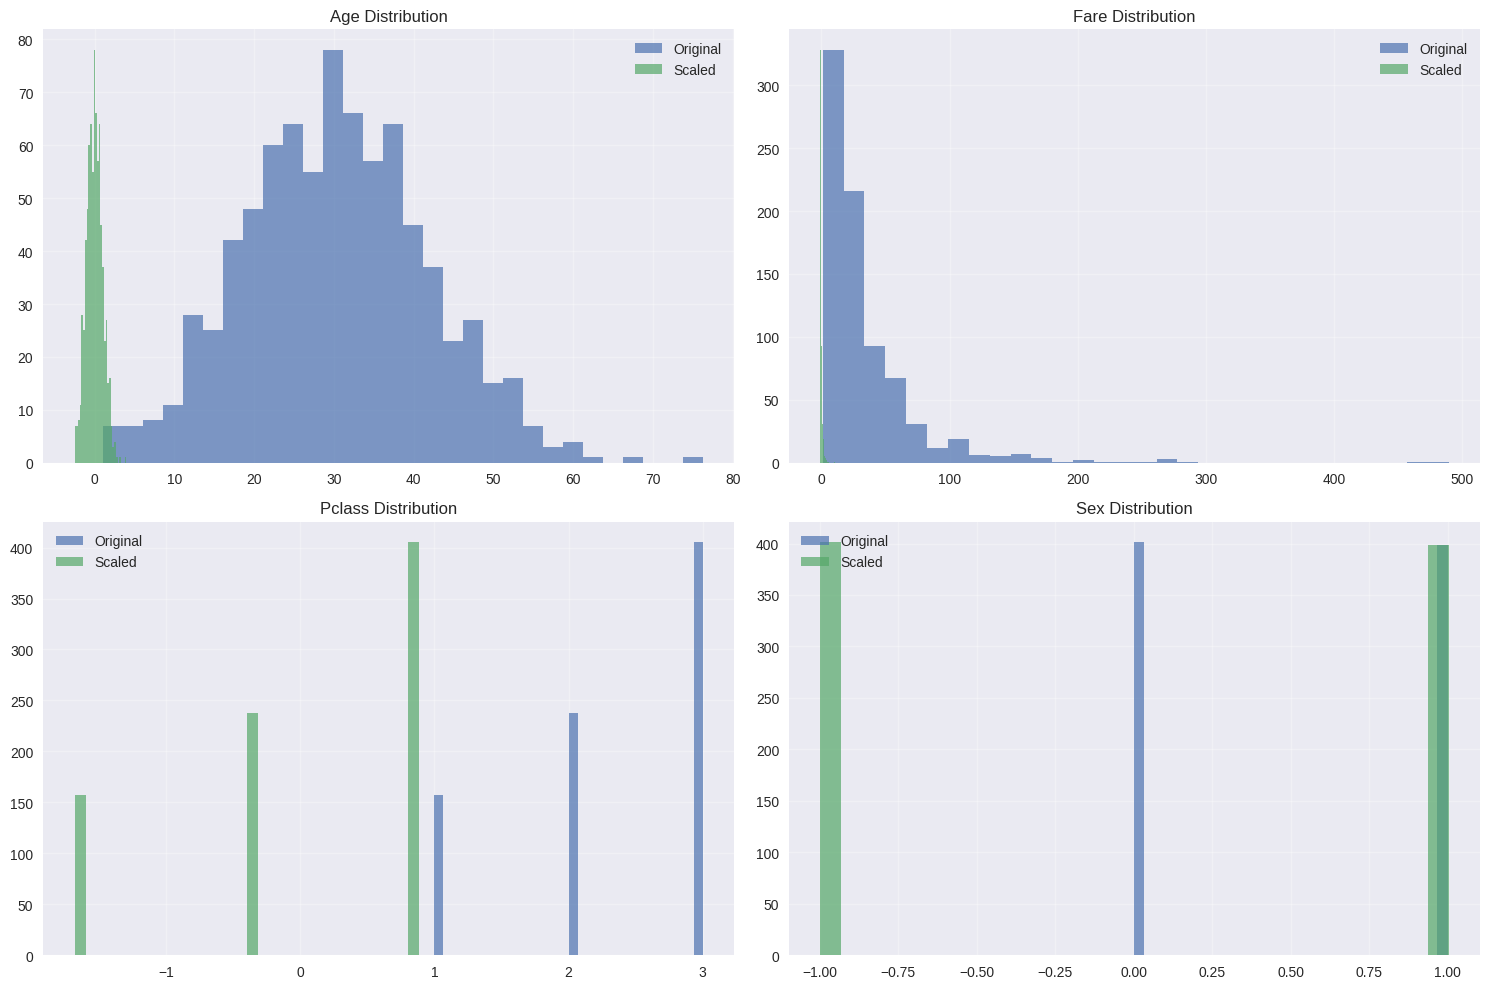

In [5]:
# Prepare features and target
X = df[['Age', 'Fare', 'Pclass', 'Sex']]
y = df['Survived']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Compare feature distributions before and after scaling
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
features = ['Age', 'Fare', 'Pclass', 'Sex']

for i, feature in enumerate(features):
    ax = axes[i//2, i%2]
    ax.hist(X_train[feature], alpha=0.7, label='Original', bins=30)
    ax.hist(X_train_scaled[:, i], alpha=0.7, label='Scaled', bins=30)
    ax.set_title(f'{feature} Distribution')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Coefficients and Interpretation:
  Feature  Coefficient  Odds_Ratio
0     Age     0.106301    1.112157
1    Fare     0.057796    1.059499
2  Pclass    -0.377049    0.685883
3     Sex     1.009494    2.744211

Intercept: -0.643


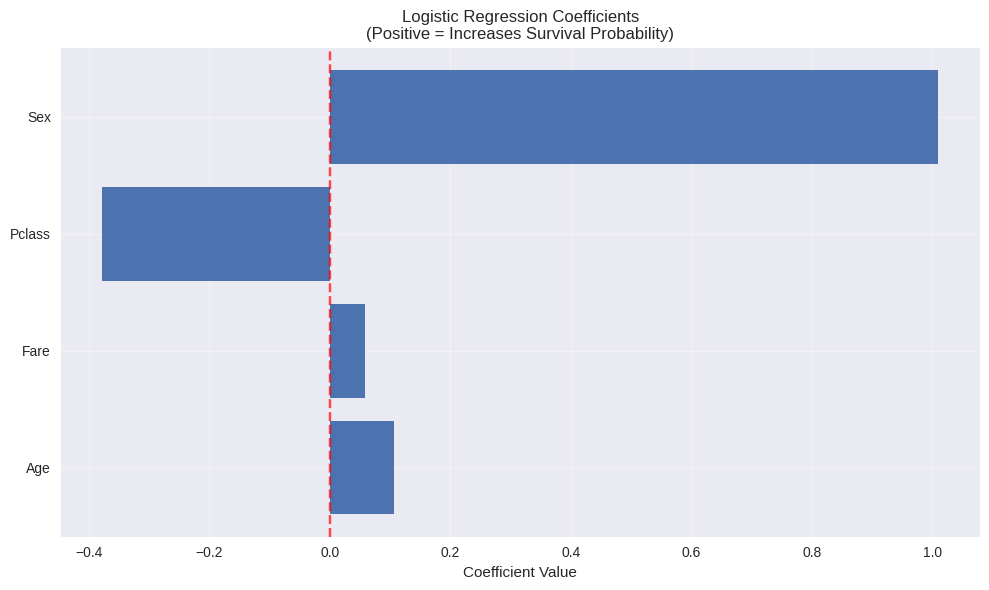

In [6]:
# Train logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Extract and interpret coefficients
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': log_reg.coef_[0],
    'Odds_Ratio': np.exp(log_reg.coef_[0])
})

print("Model Coefficients and Interpretation:")
print(coefficients)
print(f"\nIntercept: {log_reg.intercept_[0]:.3f}")

# Visualize coefficients
plt.figure(figsize=(10, 6))
plt.barh(coefficients['Feature'], coefficients['Coefficient'])
plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients\n(Positive = Increases Survival Probability)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

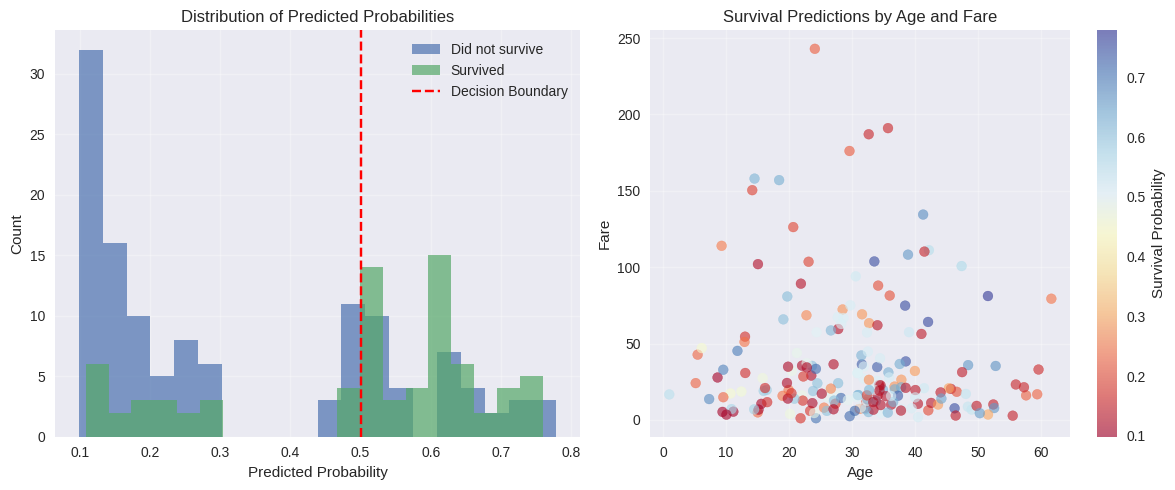

In [7]:
# Make predictions
y_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probability of survival
y_pred = log_reg.predict(X_test_scaled)  # Binary predictions (threshold = 0.5)

# Analyze predictions
prediction_analysis = pd.DataFrame({
    'Actual': y_test.values,
    'Predicted_Probability': y_pred_proba,
    'Predicted_Class': y_pred
})

# Visualize prediction distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], alpha=0.7, label='Did not survive', bins=20)
plt.hist(y_pred_proba[y_test == 1], alpha=0.7, label='Survived', bins=20)
plt.axvline(x=0.5, color='red', linestyle='--', label='Decision Boundary')
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# Scatter plot of two features with predictions
scatter = plt.scatter(X_test['Age'], X_test['Fare'], c=y_pred_proba,
                     cmap='RdYlBu', alpha=0.6, s=50)
plt.colorbar(scatter, label='Survival Probability')
plt.xlabel('Age')
plt.ylabel('Fare')
plt.title('Survival Predictions by Age and Fare')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Model Accuracy: 0.695

Detailed Classification Report:
                 precision    recall  f1-score   support

Did not survive       0.78      0.70      0.74       124
       Survived       0.58      0.68      0.63        76

       accuracy                           0.69       200
      macro avg       0.68      0.69      0.69       200
   weighted avg       0.71      0.69      0.70       200



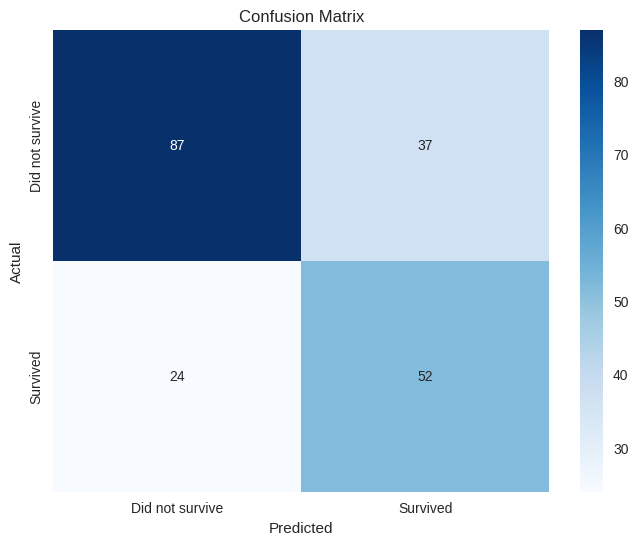

In [8]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.3f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Did not survive', 'Survived']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did not survive', 'Survived'],
            yticklabels=['Did not survive', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

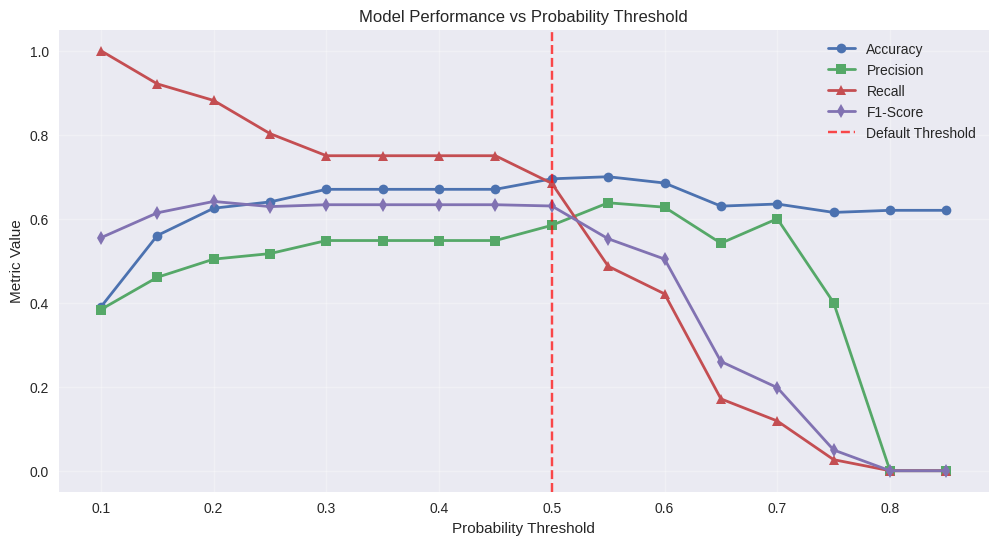

Key Takeaways:
1. Linear regression fails for classification (unbounded outputs)
2. Sigmoid function maps any real number to probability [0,1]
3. Feature scaling is crucial for logistic regression
4. Coefficients represent change in log-odds per unit increase
5. Decision threshold can be tuned based on business requirements
6. Multiple evaluation metrics provide comprehensive model assessment


In [9]:
thresholds = np.arange(0.1, 0.9, 0.05)
metrics = {'threshold': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

for threshold in thresholds:
    y_pred_thresh = (y_pred_proba >= threshold).astype(int)

    # Calculate metrics for this threshold
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = ((y_pred_thresh == 1) & (y_test == 1)).sum() / max((y_pred_thresh == 1).sum(), 1)
    rec = ((y_pred_thresh == 1) & (y_test == 1)).sum() / max((y_test == 1).sum(), 1)
    f1 = 2 * (prec * rec) / max((prec + rec), 1e-8)

    metrics['threshold'].append(threshold)
    metrics['accuracy'].append(acc)
    metrics['precision'].append(prec)
    metrics['recall'].append(rec)
    metrics['f1'].append(f1)

# Plot threshold analysis
plt.figure(figsize=(12, 6))
plt.plot(metrics['threshold'], metrics['accuracy'], 'o-', label='Accuracy', linewidth=2)
plt.plot(metrics['threshold'], metrics['precision'], 's-', label='Precision', linewidth=2)
plt.plot(metrics['threshold'], metrics['recall'], '^-', label='Recall', linewidth=2)
plt.plot(metrics['threshold'], metrics['f1'], 'd-', label='F1-Score', linewidth=2)
plt.axvline(x=0.5, color='red', linestyle='--', alpha=0.7, label='Default Threshold')
plt.xlabel('Probability Threshold')
plt.ylabel('Metric Value')
plt.title('Model Performance vs Probability Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("Key Takeaways:")
print("1. Linear regression fails for classification (unbounded outputs)")
print("2. Sigmoid function maps any real number to probability [0,1]")
print("3. Feature scaling is crucial for logistic regression")
print("4. Coefficients represent change in log-odds per unit increase")
print("5. Decision threshold can be tuned based on business requirements")
print("6. Multiple evaluation metrics provide comprehensive model assessment")